In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score
import seaborn as sns
from collections import Counter
import re

pd.set_option('display.max_colwidth', None)

In [72]:
df = pd.read_excel(r"C:\Users\Dnin\Desktop\bidnet_dataset_02122024_V1.xlsx")
df.head()

,Title,Description,Tags,Relevant?,Remarks
0,"E-Rate Cat. 2 - Wireless Network, UPS units, Data Cabling, Hardware Maintenance","The Denver Public Library (DPL) is seeking proposals for E-rate Category Two Equipment and Services - Basic Maintenance of Internal Connections, WiFi system refresh, Ad Hoc Data Cabling installation as needed, and/or UPS Units for Data Closets from vendors that have proven capable of provinding these goods and services comparable in size and scope to DPL’s. DPL is an independent agency of the City and County of Denver.",None,No,NaN
1,009-24 RFP Interpretation and Translation Services,"DCSD is requesting proposals from qualified firms or individuals for foreign and sign language interpretation and translation services needed to assist English-only speaking employees with stakeholder(s) who are hearing impaired or speak a foreign language.\nSUBMIT TO:\nDouglas County School District RE-1 (“DCSD”)\nvia:\nDCSD’s Workday Strategic Sourcing portal, which can be accessed via the link below.\nSuppliers must submit their bids within this portal.\nhttps://us.workdayspend.com/rfps/public/586486",None,No,NaN
2,Survive and Thrive: Application and Payment Provider,Boulder County Department of Housing and Human Services is seeking to contract with a business support entity for our Survive and Thrive Program.,None,No,NaN
3,Parking Garage & Parking Lot Security Services,The City of Colorado Springs Parking System Enterprise is seeking proposals to provide unarmed security services to 3 of our garages in Downtown Colorado Springs and a bicycle patrol for four of our parking lots in Old Colorado City.,None,No,NaN
4,Eaton UPS Replacements FY24,The University of Northern Colorado (“University” or “UNC”) seeks pricing for replacement Eaton UPS equipment. All equipment must be NEW. No substitutions will be considered,None,No,NaN


# Pre-Processing

In [73]:
df['Description'] = df['Title'].fillna('') + ' - ' + df['Description'].fillna('')

df['Relevant?'] = df['Relevant?'].map({'Yes': True, 'No': False}).astype(bool)

df['Tags'] = df['Tags'].apply(lambda x:[tag.strip() for tag in x.split(',')] if x != "None" else [])

# Model and Functions

In [74]:
model = SentenceTransformer('all-mpnet-base-v2')
#model = SentenceTransformer('multi-qa-mpnet-base-dot-v1')
# model.max_seq_length

In [75]:
# keywords = ["digital transformation", "artificial intelligence", "machine learning", "analytics", "data engineering",\
#             "salesforce", "grants", "licensing and permits", "lightning experience, lightning migration",\
#             "case management", "data warehouse", "automation", "rpa ; robotic process automation" , "consultancy", "advisory",\
#            "application development and maintenance"]

keywords = ["digital transformation", "artificial intelligence", "machine learning", "analytics", "data engineering",\
            "case management", "data warehouse", "automation",\
            "robotic process automation" , "advisory", "application development","document management"]

keywords_1 = ["digital transformation", "artificial intelligence", "machine learning", "analytics", "data engineering",\
            "salesforce", "grants", "licensing", "permits", "lightning experience", "lightning migration",\
            "case management", "data warehouse", "automation", "robotic process automation" , "advisory",\
           "application development","document management","apex","visualforce","einstein analytics","tableau","power bi","crm"]

keyword_embeddings = np.array([model.encode(keyword) for keyword in keywords])

In [76]:
def keyword_search(row, keywords):
    description = row['Description']
    matching_keywords = []
    for keyword in keywords:
        if re.search(keyword, description, re.IGNORECASE):  # Case insensitive search
            matching_keywords.append(keyword)
    return matching_keywords

def calculate_cosine_similarity(description_embedding):
    similarities= {}
    for keyword, keyword_embedding in zip(keywords, keyword_embeddings):
        similarity = cosine_similarity([keyword_embedding], [description_embedding])[0][0]
        similarities[keyword] = similarity
        #print(f"Similarity with '{keyword}':", similarities[keyword])
        
    return similarities

def predict_tags(row, model, keywords, keyword_embeddings, threshold):
    description = row['Description']
#     print(row['Title'])
    words = re.findall(r'\b\w+\b', description)
    number_of_words = len(words)
    actual_tags = "No Tags" if row['Tags'] == "None" else row['Tags']
    description_embedding = model.encode(description)
    
    similarities_tags = calculate_cosine_similarity(description_embedding)

#     threshold = 0.3
#     For second model threshold around 0.6
#     predicted_tags = [keyword for keyword, score in similarities_tags.items() if score > threshold]

    filtered_sorted_tags = sorted([(keyword, score) for keyword, score in similarities_tags.items() if score > threshold], key=lambda x: x[1], reverse=True)
    top_3_tags = [tag for tag, _ in filtered_sorted_tags[:3]]
#     print("Description:", description)
#     print("Actual Tags: ", actual_tags)
#     print("Predicted Tags: ", predicted_tags)
#     print("Most Relevant Tag: " max_similarity_tag)
    
    return top_3_tags, number_of_words

In [77]:
def check_relevance(row):
    relevance = True if len(row['Relevant Tags']) > 0 or len(row['Matching Tags']) > 0 else False
    return relevance

def combine_tags(row):
    # Combine both lists and use set to remove duplicates, then convert back to list
    return list(set(row['Relevant Tags']) | set(row['Matching Tags']))

In [78]:
df['Matching Tags'] = df.apply(lambda row: keyword_search(row, keywords_1), axis=1)

# Defining the threshold

In [79]:
thresholds = np.arange(0.25, 0.45, 0.01)  # Adjust step size as needed

# Lists to store metrics for each threshold
precisions = []
recalls = []
accuracies = []

for threshold in thresholds:
    temp_df = df.copy()
    
    # Predict tags and relevance for the current threshold
    temp_df[['Relevant Tags','Word Count']] = temp_df.apply(lambda row: predict_tags(row, model, keywords, keyword_embeddings, threshold), axis=1, result_type='expand')
    temp_df['Predicted Relevance'] = temp_df.apply(check_relevance, axis=1)
    
    # Calculate metrics
    precision = precision_score(temp_df['Relevant?'], temp_df['Predicted Relevance'])
    recall = recall_score(temp_df['Relevant?'], temp_df['Predicted Relevance'])
    accuracy = accuracy_score(temp_df['Relevant?'], temp_df['Predicted Relevance'])
    
    # Append metrics to lists
    precisions.append(precision)
    recalls.append(recall)
    accuracies.append(accuracy)

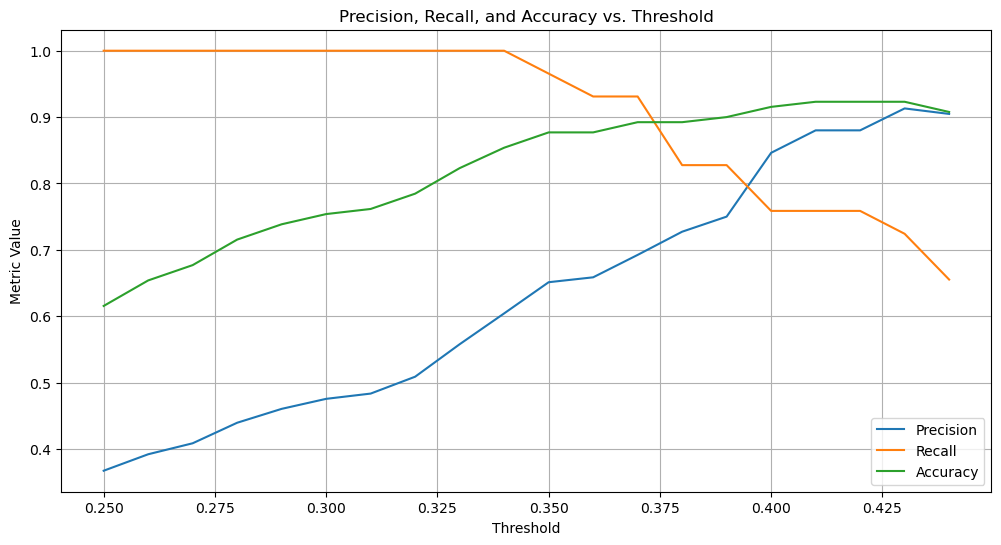

In [81]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, accuracies, label='Accuracy')
plt.xlabel('Threshold')
plt.ylabel('Metric Value')
plt.title('Precision, Recall, and Accuracy vs. Threshold')
plt.legend()
plt.grid(True)
plt.show()

# Computing Relevance

In [82]:
df['Matching Tags'] = df.apply(lambda row: keyword_search(row, keywords), axis=1)

df[['Relevant Tags','Word Count']] = df.apply(lambda row: predict_tags(row, model, keywords, keyword_embeddings, 0.36), axis=1, result_type='expand')

df['Predicted Relevance'] = df.apply(check_relevance, axis=1)

df['Combined Tags'] = df.apply(combine_tags, axis=1)

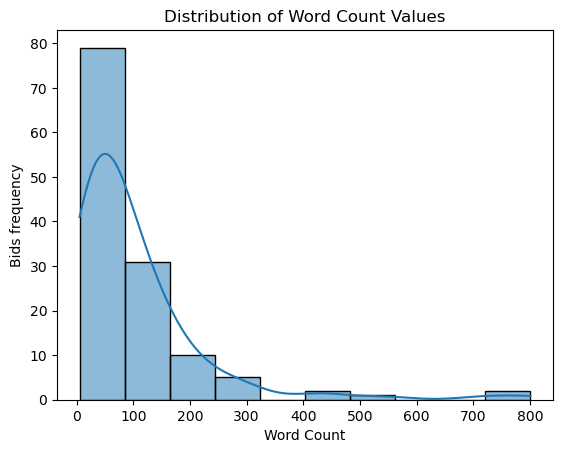

In [83]:
# df['Relevant?'].value_counts()
filtered_df = df.loc[df['Word Count'] > 350]

sns.histplot(df['Word Count'],bins=10,kde=True)
plt.xlabel('Word Count')
plt.ylabel('Bids frequency')
plt.title('Distribution of Word Count Values')
plt.show()

In [84]:
# for keyword in keywords:    
#     count = sum(row.count(keyword) for row in df['Tags'])
#     print(keyword, ": ", count)

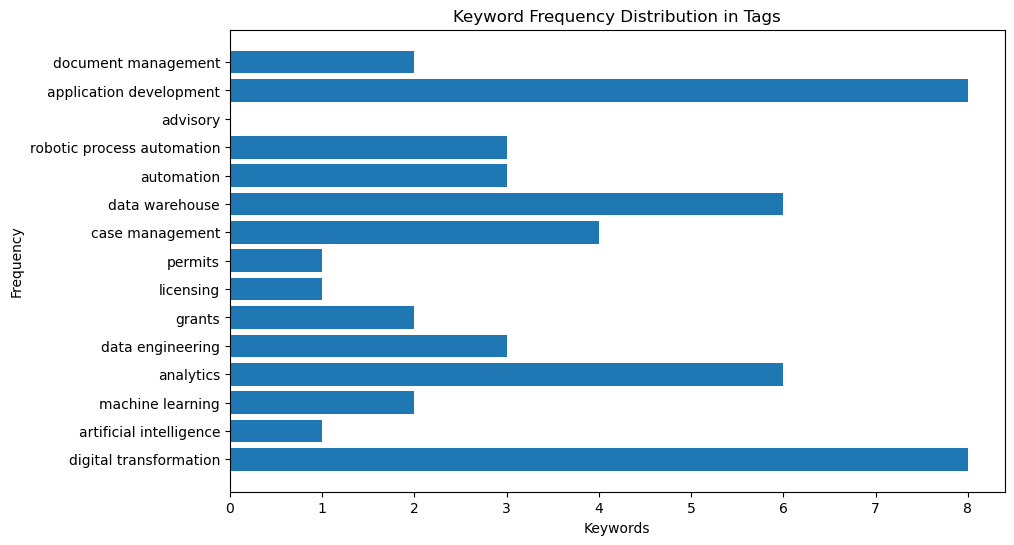

In [85]:
tag_list = [tag for tags in df['Tags'] for tag in tags]
keyword_counts = Counter(tag_list)

# Create a list of counts for each keyword
keyword_frequencies = [keyword_counts[keyword] for keyword in keywords]

# Create a bar plot for the keyword frequencies
plt.figure(figsize=(10, 6))
plt.barh(keywords, keyword_frequencies)
plt.xlabel('Keywords')
plt.ylabel('Frequency')
plt.title('Keyword Frequency Distribution in Tags')
plt.show()

In [86]:
# df['Relevant?'].value_counts()
# df['Predicted Relevance'].value_counts()

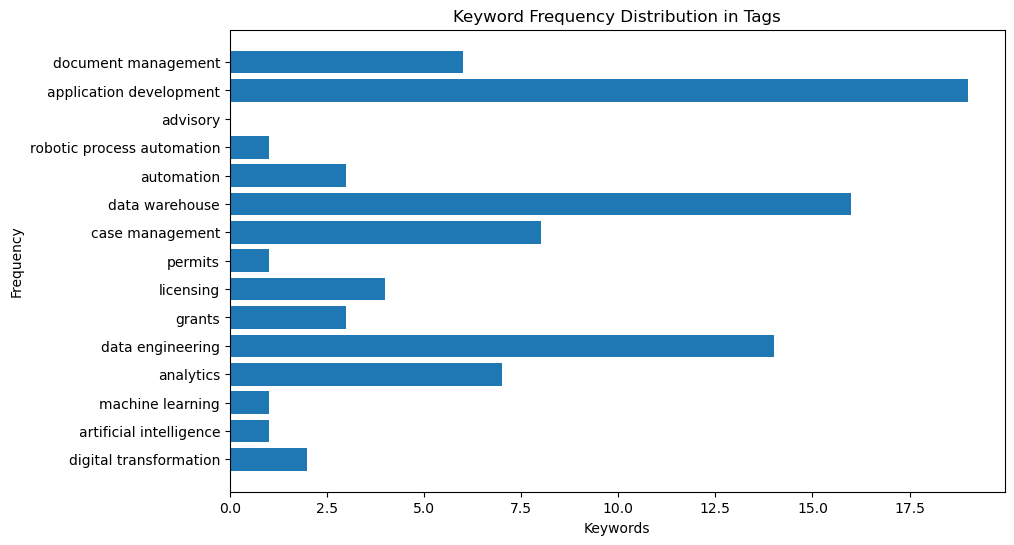

In [87]:
tag_list = [tag for tags in df['Combined Tags'] for tag in tags]
keyword_counts = Counter(tag_list)

# Create a list of counts for each keyword
keyword_frequencies = [keyword_counts[keyword] for keyword in keywords]

# Create a bar plot for the keyword frequencies
plt.figure(figsize=(10, 6))
plt.barh(keywords, keyword_frequencies)
plt.xlabel('Keywords')
plt.ylabel('Frequency')
plt.title('Keyword Frequency Distribution in Tags')
plt.show()

# Results

In [88]:
precision = precision_score(df['Relevant?'], df['Predicted Relevance'])
recall = recall_score(df['Relevant?'], df['Predicted Relevance'])
accuracy = accuracy_score(df['Relevant?'], df['Predicted Relevance'])

print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)

Precision: 0.6585365853658537
Recall: 0.9310344827586207
Accuracy: 0.8769230769230769


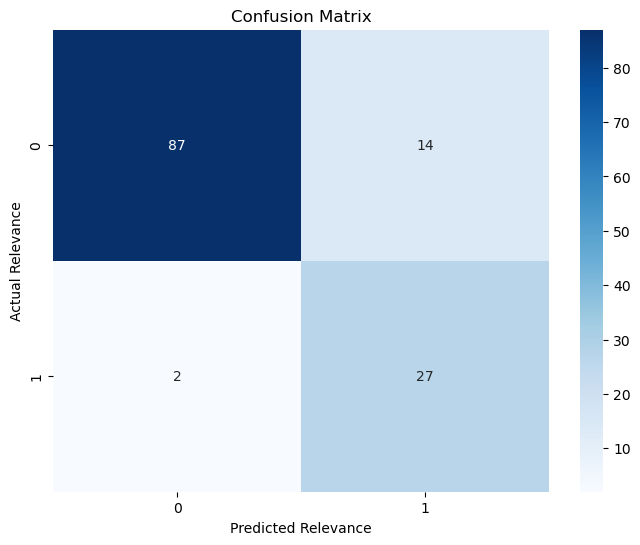

In [89]:
conf_mat = confusion_matrix(df['Relevant?'], df['Predicted Relevance'])
# Plotting Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Relevance')
plt.ylabel('Actual Relevance')
plt.show()

# Testing

In [90]:
filtered_df = df.loc[(df['Relevant?'] == True) & (df['Predicted Relevance'] == False)]
print(filtered_df['Description'])
print(filtered_df['Tags'])

35                                                                                                                                                                                                                                                                   Individualized Education Plan (IEP) and 504 Software System - The District is seeking proposals from qualified vendors to provide an Individualized Education Plan (IEP) and 504 Software System able to meet Colorado State reporting requirements. The software system must be accessible and user-friendly for educators, administrators, and parents. The goal is to streamline the process of creating and managing IEPs and 504s.
116    Enterprise Systems Audit and Consulting Services - The St. Vrain Valley School District is seeking a consultant to assess and document the current state of systems used to manage Finance, Human Resources, and Student Information business processes and to prepare a comprehensive summary of the current state 

In [91]:
filtered_df = df.loc[(df['Relevant?'] == False) & (df['Predicted Relevance'] == True)]
print(filtered_df['Description'])
print(filtered_df['Combined Tags'])

8                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         Software and Implementation Services for an Enterprise Asset Management System - Proposals will only be accepted from those fi

In [70]:
filtered_df = df[df['Combined Tags'].apply(lambda x: 'crm' in x)]
print(filtered_df['Description'])

# keywords = ["digital transformation", "artificial intelligence", "machine learning", "analytics", "data engineering",\
#             "salesforce", "grants", "licensing", "permits", "lightning experience", "lightning migration",\
#             "case management", "data warehouse", "automation", "rpa", "robotic process automation" , "consultancy", "advisory",\
#            "application development","document management"]

5                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [215]:
filtered_df = df[df['Relevant Tags'].apply(lambda x: 'artificial intelligence' in x)]
print(filtered_df['Description'])

126    The City of Fort Collins is requesting proposals from qualified Service Providers to purchase an automated road condition, data collection and Artificial Intelligence (AI) based analysis service/system using dash mounted camera phones on City vehicles to inventory City assets, and to help identify the nature of road distresses using artificial intelligence to categorize, calculate and store the data. The implementation will ideally be completed during the first quarter of 2024. This new service/system would complement the City’s current pavement condition survey by providing more current and frequent data collection and analysis.  The stored data is to have an on-line portal for viewing the data spatially and be able to be linked to Arc GIS software.
Name: Description, dtype: object


In [28]:
def has_matching_tag(row):
    return any(tag in row['Tags'] for tag in row['Combined Tags'])

# Filtering DataFrame for rows where 'Relevant' is True
relevant_df = df[df['Relevant?'] == True]

# Applying the function to each relevant row
relevant_df['match'] = relevant_df.apply(has_matching_tag, axis=1)

# Calculating accuracy for the relevant rows
accuracy = relevant_df['match'].mean()
print(f"Accuracy among relevant rows: {accuracy:.2f}")

Accuracy among relevant rows: 0.84


C:\Users\Dnin\AppData\Local\Temp\ipykernel_27780\939034296.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  relevant_df['match'] = relevant_df.apply(has_matching_tag, axis=1)
